In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt

pd.set_option('display.max_columns', None)

In [2]:
PATH_TO_DATA = '/home/marius/Jülich/Experiments/COSY Beamtime spring 2018/'

In [3]:
# systematic measurements
RUNS = range(34,104)
PARTICLES = ['Proton', 'Deuteron']
ENERGIES = [10,20,30,40]

In [4]:
# current sensitivity Be (1 V equivalent in nA)
sense = {34:1,
         35:1,
         36:1,
         37:1,
         38:1,
         39:1,
         40:1,
         41:1,
         42:1,
         43:1,
         44:1,
         45:1,
         46:1,
         47:1,
         48:1,
         49:1,
         50:1,
         51:1,
         52:1,
         53:1,
         54:0.01,
         55:0.01,
         56:0.01,
         57:0.01,
         58:0.01,
         59:0.01,
         60:0.01,
         61:0.01,
         62:0.01,
         63:0.01,
         64:0.01,
         65:0.1,
         66:0.1,
         67:0.1,
         68:0.1,
         69:0.1,
         70:0.1,
         71:0.1,
         72:0.1,
         73:0.1,
         74:0.1,
         75:0.1,
         76:0.1,
         77:0.1,
         78:0.1,
         79:0.1,
         80:0.1,
         81:0.1,
         82:0.1,
         83:0.01,
         84:0.01,
         85:0.01,
         86:0.01,
         87:0.01,
         88:0.01,
         89:0.01,
         90:0.01,
         91:0.01,
         92:0.01,
         93:0.01,
         94:0.01,
         95:0.01,
         96:0.01,
         97:0.01,
         98:0.01,
         99:0.01,
         100:0.01,
         101:0.01,
         102:0.01,
         103:0.01}

df_sense = pd.DataFrame.from_dict(sense, orient='index').reset_index().rename(columns = {'index':'run_number', 0:'curr_sense [nA]'})

### helper

In [5]:
def read_syst_data(run_number, particle, energy):
    df = pd.read_table(
        PATH_TO_DATA + 'RawData/Current/#{}_H3_Current_{}MeV_{}.dat'.format(run_number, energy, particle), 
        header = None, 
        delim_whitespace=True,
        names = ['timestamp',
                 '3-He_1',
                 '3-He_2',
                 '3-He_3',
                 '3-He_4',
                 '3-He_5',
                 '3-He_6',
                 '3-He_7',
                 'meas.',
                 'I_Be',
                 'I_J',
                 'I_FCT',
                 'I_BPML',
                 'I_BPMR',
                 'I_ICT'
                ]
    )
    return df

In [6]:
# quadrature propagation of error for mean value
def quadrature_prop(x):
    square = x**2
    count  = x.count()
    return 1/count * (square.sum())**0.5

### data preparation

In [7]:
# put all systematic measurements in one dataframe

df = pd.DataFrame()

for run_number in RUNS:
    for particle in PARTICLES:
        for energy in ENERGIES:
            
            try:
                df_temp = read_syst_data(run_number, particle, energy)
                
                df_temp['run_number'] = run_number
                df_temp['particle'] = particle
                df_temp['energy [MeV]'] = energy
            except:
                pass
            
    df = df.append(df_temp)

In [8]:
# runs with wrong current scale (not working)
df = df[~df['run_number'].isin([51,52,53])]

In [9]:

# read gnumeric data and merge target information (+ additional)

summary = pd.read_table(PATH_TO_DATA + 'Summary.csv', sep = ',')
# get rid of empty lines and mixed runs
summary.dropna(subset = ['Run'], inplace = True)
summary = summary[(summary['Run'] != '#105/106') & (summary['Run'] != '#107/108')]
# prepare for merging
summary['run_number'] = summary['Run'].apply(str).apply(lambda row: row.strip('#')).apply(int)
summary.rename(
    columns = {'Unnamed: 10':'scale',
               'I Be':'I_Be mean',
               'Unnamed: 12':'I_Be std',
               'I J':'I_J mean',
               'Unnamed: 16':'I_J std',
               'I FCT':'I_FCT mean',
               'Unnamed: 18':'I_FCT std',
               'I ICT':'I_ICT mean',
               'Unnamed: 20':'I_ICT std',
               'Unnamed: 25':'int_H',
               'Unnamed: 26':'int_H error'
              },
    inplace = True
)


In [10]:
# build aggregation dictionary
currents = [s for s in df.columns if 'I_' in s]

d = {}
for current in currents:
    d[current] = ['mean','std']
curr_dict = d

In [11]:
# calc. mean and std of currents for each run
df_currents = df.groupby(
    ['run_number',
     'particle',
     'energy [MeV]']
).agg(
    curr_dict
).reset_index()

# make multiindex to single level index for merging
df_currents.columns = [' '.join(col).strip() for col in df_currents.columns.values]

# calc. sum signal of BPML and BPMR
df_currents['I_BPMS mean'] = df_currents['I_BPML mean'] + df_currents['I_BPMR mean']
df_currents['I_BPMS std'] = np.sqrt(df_currents['I_BPML std']**2 + df_currents['I_BPMR std']**2)

In [12]:
df_currents.head()

,run_number,particle,energy [MeV],I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean,I_ICT std,I_Be mean,I_Be std,I_J mean,I_J std,I_FCT mean,I_FCT std,I_BPMS mean,I_BPMS std
0,34,Proton,40,1.752275,1.876376,1.018408,1.680033,0.000140,0.028256,0.083109,0.269519,0.915094,0.895642,4.327421,2.513941,2.770683,2.518591
1,35,Proton,40,5.396881,0.613262,4.188999,0.619018,0.000265,0.028223,0.039985,0.062917,3.025304,0.313791,9.204697,1.017498,9.585880,0.871363
2,36,Proton,40,3.892275,0.076886,2.702237,0.075832,0.000323,0.028256,0.024764,0.062015,2.243727,0.131426,6.883327,0.290023,6.594513,0.107990
3,37,Proton,30,8.615095,0.095526,7.584437,0.097846,0.000286,0.028326,0.499853,0.065930,5.600712,0.316638,9.954364,0.324535,16.199532,0.136744
4,38,Proton,30,8.868670,0.151789,7.769169,0.155411,0.000262,0.028403,0.022703,0.064794,4.844619,0.418063,10.581204,0.229646,16.637840,0.217239


In [13]:
# merge calc. currents with PZ currents & Target information
df_total = df_currents.merge(
    summary[
    ['run_number',
     'Target',
     'Start',
     'End',
     'I_Be mean',
     'I_Be std',
     'I_J mean',
     'I_J std',
     'I_FCT mean',
     'I_FCT std',
     'I_ICT mean',
     'I_ICT std']
    ], 
    on = 'run_number',
    how = 'left',
    suffixes = ('_MR','_PZ')
).merge(
    df_sense,
    on = 'run_number',
    how = 'left'
)

In [14]:
df_total.head()

,run_number,particle,energy [MeV],I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean_MR,I_ICT std_MR,I_Be mean_MR,I_Be std_MR,I_J mean_MR,I_J std_MR,I_FCT mean_MR,I_FCT std_MR,I_BPMS mean,I_BPMS std,Target,Start,End,I_Be mean_PZ,I_Be std_PZ,I_J mean_PZ,I_J std_PZ,I_FCT mean_PZ,I_FCT std_PZ,I_ICT mean_PZ,I_ICT std_PZ,curr_sense [nA]
0,34,Proton,40,1.752275,1.876376,1.018408,1.680033,0.000140,0.028256,0.083109,0.269519,0.915094,0.895642,4.327421,2.513941,2.770683,2.518591,Be,20:26:00,20:56:00,Error,NaN,"3,3912","0,4427","11,001","0,0004",NaN,NaN,1.0
1,35,Proton,40,5.396881,0.613262,4.188999,0.619018,0.000265,0.028223,0.039985,0.062917,3.025304,0.313791,9.204697,1.017498,9.585880,0.871363,X,21:32:00,22:02:00,"0,04","0,063","3,02","0,312","9,2047","1,017",NaN,NaN,1.0
2,36,Proton,40,3.892275,0.076886,2.702237,0.075832,0.000323,0.028256,0.024764,0.062015,2.243727,0.131426,6.883327,0.290023,6.594513,0.107990,X,22:11:00,22:41:00,"0,0248","0,062","2,2437","0,1314","6,8833","0,29",NaN,NaN,1.0
3,37,Proton,30,8.615095,0.095526,7.584437,0.097846,0.000286,0.028326,0.499853,0.065930,5.600712,0.316638,9.954364,0.324535,16.199532,0.136744,Be,23:34:00,00:04:00,"0,5","0,07","5,6","0,317","9,9544","0,3245",NaN,NaN,1.0
4,38,Proton,30,8.868670,0.151789,7.769169,0.155411,0.000262,0.028403,0.022703,0.064794,4.844619,0.418063,10.581204,0.229646,16.637840,0.217239,X,00:27:00,02:57:00,"0,0227","0,0648","4,8446","0,418","10,5812","0,2296",NaN,NaN,1.0


In [15]:
# compare MR and PZ calc. currents
df_total[
    [
        'run_number',
        'I_Be mean_MR',
        'I_Be mean_PZ'
    ]
].head(10)

,run_number,I_Be mean_MR,I_Be mean_PZ
0,34,0.083109,Error
1,35,0.039985,"0,04"
2,36,0.024764,"0,0248"
3,37,0.499853,"0,5"
4,38,0.022703,"0,0227"
5,39,0.024803,"0,0248"
6,40,0.026237,"0,0262"
7,41,0.386435,"0,3864"
8,42,0.044807,"0,0448"
9,43,0.385403,"0,3854"


### interpolate missing I_Be where Target == X

In [16]:
# historic renaming
df_curr_sense = df_total

# calc. ratio of Be current and BPM current
df_curr_sense['ratio Be/BPMS'] = df_curr_sense['I_Be mean_MR'] / df_curr_sense['I_BPMS mean']

# calc. mean of ratio for runs with target (spec by part., energy AND current scale!)
df_mean_ratio = df_curr_sense[
    df_curr_sense['Target'] == 'Be'
].groupby(
    ['particle',
     'energy [MeV]',
     'curr_sense [nA]'
    ]
).agg(
    {'ratio Be/BPMS':'mean'}
).reset_index()

# merge mean to original df
df_curr_sense = df_curr_sense.merge(
    df_mean_ratio,
    on = ['particle','energy [MeV]','curr_sense [nA]'],
    how = 'left',
    suffixes = ('', ' mean')
)

In [17]:
df_curr_sense.head()

,run_number,particle,energy [MeV],I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean_MR,I_ICT std_MR,I_Be mean_MR,I_Be std_MR,I_J mean_MR,I_J std_MR,I_FCT mean_MR,I_FCT std_MR,I_BPMS mean,I_BPMS std,Target,Start,End,I_Be mean_PZ,I_Be std_PZ,I_J mean_PZ,I_J std_PZ,I_FCT mean_PZ,I_FCT std_PZ,I_ICT mean_PZ,I_ICT std_PZ,curr_sense [nA],ratio Be/BPMS,ratio Be/BPMS mean
0,34,Proton,40,1.752275,1.876376,1.018408,1.680033,0.000140,0.028256,0.083109,0.269519,0.915094,0.895642,4.327421,2.513941,2.770683,2.518591,Be,20:26:00,20:56:00,Error,NaN,"3,3912","0,4427","11,001","0,0004",NaN,NaN,1.0,0.029996,0.029996
1,35,Proton,40,5.396881,0.613262,4.188999,0.619018,0.000265,0.028223,0.039985,0.062917,3.025304,0.313791,9.204697,1.017498,9.585880,0.871363,X,21:32:00,22:02:00,"0,04","0,063","3,02","0,312","9,2047","1,017",NaN,NaN,1.0,0.004171,0.029996
2,36,Proton,40,3.892275,0.076886,2.702237,0.075832,0.000323,0.028256,0.024764,0.062015,2.243727,0.131426,6.883327,0.290023,6.594513,0.107990,X,22:11:00,22:41:00,"0,0248","0,062","2,2437","0,1314","6,8833","0,29",NaN,NaN,1.0,0.003755,0.029996
3,37,Proton,30,8.615095,0.095526,7.584437,0.097846,0.000286,0.028326,0.499853,0.065930,5.600712,0.316638,9.954364,0.324535,16.199532,0.136744,Be,23:34:00,00:04:00,"0,5","0,07","5,6","0,317","9,9544","0,3245",NaN,NaN,1.0,0.030856,0.030856
4,38,Proton,30,8.868670,0.151789,7.769169,0.155411,0.000262,0.028403,0.022703,0.064794,4.844619,0.418063,10.581204,0.229646,16.637840,0.217239,X,00:27:00,02:57:00,"0,0227","0,0648","4,8446","0,418","10,5812","0,2296",NaN,NaN,1.0,0.001365,0.030856


In [18]:
# calculate Be current for meas. w/o target
df_curr_sense.loc[
    df_curr_sense['Target'] == 'X',
    'I_Be mean_MR'] = df_curr_sense['ratio Be/BPMS mean'] * df_curr_sense['I_BPMS mean']

df_curr_sense.loc[
    df_curr_sense['Target'] == 'X',
    'I_Be std_MR'] = df_curr_sense['ratio Be/BPMS mean'] * df_curr_sense['I_BPMS std']

In [19]:
df_curr_sense[
    ['run_number',
     'particle',
     'energy [MeV]',
     'Target',
     'curr_sense [nA]',
     'I_Be mean_MR',
     'I_BPMS mean',
     'ratio Be/BPMS mean']
].tail(10)
# what about the NaNs??

,run_number,particle,energy [MeV],Target,curr_sense [nA],I_Be mean_MR,I_BPMS mean,ratio Be/BPMS mean
49,94,Deuteron,10,Be,0.01,2.902206,2.766530,1.072277
50,95,Deuteron,10,Be,0.01,4.517125,4.188532,1.072277
51,96,Deuteron,10,X,0.01,4.372907,4.078149,1.072277
52,97,Deuteron,10,X,0.01,4.303152,4.013096,1.072277
53,98,Deuteron,10,X,0.01,4.442439,4.142994,1.072277
54,99,Deuteron,10,X,0.01,4.590335,4.280921,1.072277
55,100,Deuteron,10,X,0.01,4.599679,4.289636,1.072277
56,101,Deuteron,10,X,0.01,4.552631,4.245758,1.072277
57,102,Deuteron,10,X,0.01,4.482375,4.180238,1.072277
58,103,Deuteron,10,X,0.01,4.270313,3.982471,1.072277


### get EPICS data and merge

In [20]:
df_EPICS = pd.DataFrame()

for filename in os.listdir(PATH_TO_DATA + 'EPICS Current/'):
    run = filename.split('_')[0].strip('#')
    df_temp = pd.read_csv(
        PATH_TO_DATA + 'EPICS Current/#{}_EPICS.csv'.format(run),
        header = None, usecols = [1,3],
        names = ['sec', 'I_Be EPICS']
    )
    
    df_temp['run_number'] = int(run)
    
    df_EPICS = df_EPICS.append(df_temp)
    
# convert UNIX timestamp
df_EPICS['time'] = df_EPICS['sec'].apply(dt.fromtimestamp)
df_EPICS.sort_values('time', inplace = True)

# get measurement intervals
df_EPICS = df_EPICS.merge(df_total[['run_number','Start','End']], on = 'run_number')
df_EPICS['Start'] = df_EPICS['Start'].apply(lambda x: dt.strptime(x,'%H:%M:%S').time())
df_EPICS['End'] = df_EPICS['End'].apply(lambda x: dt.strptime(x,'%H:%M:%S').time())

In [21]:
def filter_meas(df, start_col, end_col, time_col):
    
    # prepare for appending
    df.reset_index()
    
    # regular intervals
    df1 = df[df[start_col] < df[end_col]]
    df1 = df1[df1[time_col].apply(lambda x: x.time()).between(df1[start_col],df1[end_col])]
    
    # day change
    df2 = df[df[start_col] > df[end_col]]
    df2 = df2[(df2[time_col].apply(lambda x: x.time()) > df2[start_col])
              | (df2[time_col].apply(lambda x: x.time()) < df2[end_col])
             ]
    
    return df1.append(df2)    

In [22]:
df_EPICS_filter = filter_meas(df_EPICS, 'Start', 'End', 'time')

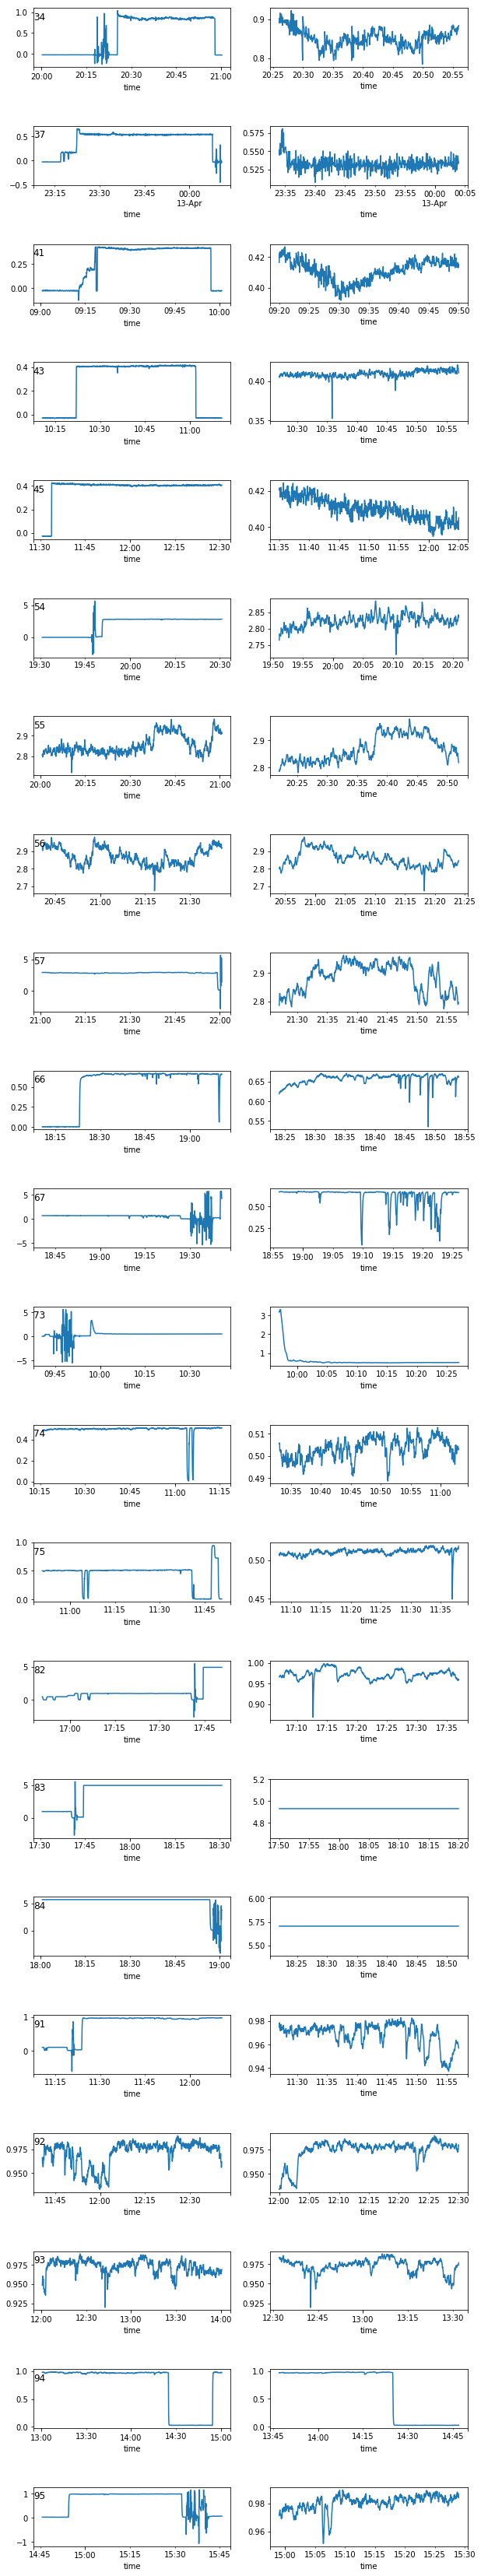

In [23]:
fig, ax = plt.subplots(df_EPICS['run_number'].nunique(),2, figsize = (10,60))

fig.subplots_adjust(hspace=1)

for num,run in enumerate(df_EPICS['run_number'].unique()):
    
    ax1 = ax[num,0]
    ax1.set_title(str(run), loc='left', pad=-15.)
    
    ax2 = ax[num,1]
    
    df_run =  df_EPICS[df_EPICS['run_number'] == run]
    
    # plot regular measurement
    df_run.plot('time',
                'I_Be EPICS',
                legend = False,
                ax = ax1
               )
    
    # mean of currents
    mean = df_run['I_Be EPICS'].mean()
    
    # df with currents only in interval
    df_filter = df_EPICS_filter[df_EPICS_filter['run_number'] == run]
        
    df_filter.plot('time',
                   'I_Be EPICS',
                   legend = False,
                   ax = ax2
                  )

In [24]:
df_EPICS_mean = df_EPICS_filter.groupby('run_number').agg({'I_Be EPICS':['mean','std']}).reset_index().sort_values('run_number')

# make multiindex to single level index for merging
df_EPICS_mean.columns = [' '.join(col).strip() for col in df_EPICS_mean.columns.values]

In [25]:
# compare EPICS current values to our current values
df_compare = df_total[
                ['run_number',
                 'particle',
                 'Target',
                 'energy [MeV]',
                 'I_Be mean_MR',
                 'I_Be std_MR',
                 'I_Be mean_PZ',
                 'I_Be std_PZ'
                ]
].merge(df_EPICS_mean, 
        on = 'run_number',
        how = 'inner'
       ).merge(df_sense,
              on = 'run_number',
              how = 'left')

df_compare.head()

,run_number,particle,Target,energy [MeV],I_Be mean_MR,I_Be std_MR,I_Be mean_PZ,I_Be std_PZ,I_Be EPICS mean,I_Be EPICS std,curr_sense [nA]
0,34,Proton,Be,40,0.083109,0.269519,Error,NaN,0.851845,0.022908,1.0
1,37,Proton,Be,30,0.499853,0.065930,"0,5","0,07",0.532296,0.009144,1.0
2,41,Proton,Be,20,0.386435,0.066667,"0,3864","0,0667",0.411122,0.007064,1.0
3,43,Proton,Be,20,0.385403,0.065672,"0,3854","0,0657",0.409595,0.004102,1.0
4,45,Proton,Be,20,0.384976,0.064492,"0,385","0,0645",0.409994,0.005910,1.0


In [26]:
df_compare['ratio EPICS / meas'] = df_compare['I_Be EPICS mean'] / df_compare['I_Be mean_MR']

In [27]:
df_compare.head()
# observations: 
# - EPICS has constant offset
# - run 83/84 show unchanged current value throughout measurement (?!)
# - from run 91: offset value changed and stays

,run_number,particle,Target,energy [MeV],I_Be mean_MR,I_Be std_MR,I_Be mean_PZ,I_Be std_PZ,I_Be EPICS mean,I_Be EPICS std,curr_sense [nA],ratio EPICS / meas
0,34,Proton,Be,40,0.083109,0.269519,Error,NaN,0.851845,0.022908,1.0,10.249746
1,37,Proton,Be,30,0.499853,0.065930,"0,5","0,07",0.532296,0.009144,1.0,1.064905
2,41,Proton,Be,20,0.386435,0.066667,"0,3864","0,0667",0.411122,0.007064,1.0,1.063885
3,43,Proton,Be,20,0.385403,0.065672,"0,3854","0,0657",0.409595,0.004102,1.0,1.062769
4,45,Proton,Be,20,0.384976,0.064492,"0,385","0,0645",0.409994,0.005910,1.0,1.064986


In [28]:
# offset seems energy dependent: increases w/ smaller energy?!
# interpolate missing value from EPICS for run 34 
reasonable_ratio = [37,41,43,45,54,55,56,57,66,67,73,74,75,82]
offset = df_compare[df_compare['run_number'].isin(reasonable_ratio)]['ratio EPICS / meas'].mean()
std = df_compare[df_compare['run_number'].isin(reasonable_ratio)]['ratio EPICS / meas'].std()

df_compare.loc[df_compare['run_number'] == 34,
               'derived I_Be'
              ] = df_compare.loc[df_compare['run_number'] == 34,
                                 'I_Be EPICS mean'
                                ] / offset

# propagate uncertainty
df_compare.loc[df_compare['run_number'] == 34,
               'derived I_Be error'
              ] = df_compare.loc[df_compare['run_number'] == 34,
               'derived I_Be'
              ] * ((df_compare.loc[df_compare['run_number'] == 34,
                                 'I_Be EPICS std'
                                ] / df_compare.loc[df_compare['run_number'] == 34,
                                 'I_Be EPICS mean'
                                ])**2 + (std / offset)**2)**0.5



df_compare.head()

,run_number,particle,Target,energy [MeV],I_Be mean_MR,I_Be std_MR,I_Be mean_PZ,I_Be std_PZ,I_Be EPICS mean,I_Be EPICS std,curr_sense [nA],ratio EPICS / meas,derived I_Be,derived I_Be error
0,34,Proton,Be,40,0.083109,0.269519,Error,NaN,0.851845,0.022908,1.0,10.249746,0.794988,0.023339
1,37,Proton,Be,30,0.499853,0.065930,"0,5","0,07",0.532296,0.009144,1.0,1.064905,NaN,NaN
2,41,Proton,Be,20,0.386435,0.066667,"0,3864","0,0667",0.411122,0.007064,1.0,1.063885,NaN,NaN
3,43,Proton,Be,20,0.385403,0.065672,"0,3854","0,0657",0.409595,0.004102,1.0,1.062769,NaN,NaN
4,45,Proton,Be,20,0.384976,0.064492,"0,385","0,0645",0.409994,0.005910,1.0,1.064986,NaN,NaN


### analyzing normalized neutron yield

In [29]:
# current df (impute all missing I_Be currents)
# currents w/ target (impute from EPICS)
df_current = df_compare[['run_number','particle','Target','energy [MeV]','I_Be mean_MR', 'I_Be std_MR','curr_sense [nA]']]

# currents w/o target (impute from BPMs)
df_wo_target = df_curr_sense[df_curr_sense['Target'] == 'X'][['run_number','particle','Target','energy [MeV]', 'I_Be mean_MR', 'I_Be std_MR','curr_sense [nA]']]

# append dfs
df_current = df_current.append(df_wo_target, ignore_index=True).sort_values('run_number')

# rename and replace missing values
df_current.rename(columns = {'I_Be mean_MR':'I_Be', 'I_Be std_MR': 'I_Be error'}, inplace = True)
df_current.loc[df_current['run_number'] == 34, 'I_Be'] = df_compare.loc[df_compare['run_number'] == 34, 'derived I_Be']
df_current.loc[df_current['run_number'] == 34, 'I_Be error'] = df_compare.loc[df_compare['run_number'] == 34,'derived I_Be error']

# calc. true current value
df_current['I_Be [nA]'] = df_current['I_Be'] * df_current['curr_sense [nA]']
df_current['I_Be error [nA]'] = df_current['I_Be error'] * df_current['curr_sense [nA]']

df_current.head()

,run_number,particle,Target,energy [MeV],I_Be,I_Be error,curr_sense [nA],I_Be [nA],I_Be error [nA]
0,34,Proton,Be,40,0.794988,0.023339,1.0,0.794988,0.023339
22,35,Proton,X,40,0.287536,0.026137,1.0,0.287536,0.026137
23,36,Proton,X,40,0.197808,0.003239,1.0,0.197808,0.003239
1,37,Proton,Be,30,0.499853,0.065930,1.0,0.499853,0.065930
24,38,Proton,X,30,0.513377,0.006703,1.0,0.513377,0.006703


In [30]:
df_n = df_current.merge(summary[['run_number','LT','int_H','int_H error']], on = 'run_number')
# calculate neutron yield. Norm. to LT, current. Subtract background (also norm. to LT, curr.)

df_n.dropna(inplace = True)

df_n['int_H'] = df_n['int_H'].apply(lambda x: float(x.replace(',','.')))
df_n['int_H error'] = df_n['int_H error'].apply(lambda x: float(x.replace(',','.')))
df_n['LT'] = df_n['LT'].apply(lambda x: float(x.replace(',','.')))

# calculate normalized neutron yield + propagate error
df_n['yield'] = df_n['int_H'] / df_n['I_Be [nA]'] / df_n['LT']
df_n['yield error'] = df_n['yield'] * ((df_n['int_H error'] / df_n['int_H'])**2 + (df_n['I_Be error [nA]'] / df_n['I_Be [nA]'])**2)**0.5
df_n.head()

,run_number,particle,Target,energy [MeV],I_Be,I_Be error,curr_sense [nA],I_Be [nA],I_Be error [nA],LT,int_H,int_H error,yield,yield error
0,34,Proton,Be,40,0.794988,0.023339,1.0,0.794988,0.023339,1351.3,449640.0,5395.68,418.555299,13.274936
1,35,Proton,X,40,0.287536,0.026137,1.0,0.287536,0.026137,1660.0,7200.0,403.20,15.084525,1.610511
2,36,Proton,X,40,0.197808,0.003239,1.0,0.197808,0.003239,1702.0,4657.0,186.28,13.832580,0.597876
3,37,Proton,Be,30,0.499853,0.065930,1.0,0.499853,0.065930,1543.0,221290.0,4647.09,286.915382,38.320592
4,38,Proton,X,30,0.513377,0.006703,1.0,0.513377,0.006703,1662.0,8240.0,337.84,9.657389,0.415546


In [31]:
test = df_n[df_n['Target']=='Be'][['particle','energy [MeV]','I_Be [nA]','I_Be error [nA]']]

test

,particle,energy [MeV],I_Be [nA],I_Be error [nA]
0,Proton,40,0.794988,0.023339
3,Proton,30,0.499853,0.065930
7,Proton,20,0.386435,0.066667
8,Proton,20,0.385403,0.065672
9,Proton,20,0.384976,0.064492
14,Proton,10,0.026305,0.000840
15,Proton,10,0.026732,0.000942
16,Proton,10,0.026629,0.000943
17,Proton,10,0.026887,0.000954
25,Deuteron,40,0.058542,0.009024


In [32]:
# average over measurement series for an energy
df_n_mean = df_n.groupby(['particle','Target','energy [MeV]']).agg({'yield':['mean','std','count'],'yield error':quadrature_prop}).reset_index()
df_n_mean.columns = [' '.join(col).strip() for col in df_n_mean.columns.values]

# fill NaNs with 0
df_n_mean.fillna(0,inplace = True)
df_n_mean.head()

,particle,Target,energy [MeV],yield mean,yield std,yield count,yield error quadrature_prop
0,Deuteron,Be,10,127.361519,3.819725,5,18.085003
1,Deuteron,Be,20,316.664730,5.924937,3,6.614114
2,Deuteron,Be,30,543.415575,31.223054,3,85.486450
3,Deuteron,Be,40,941.095727,0.000000,1,146.059734
4,Deuteron,X,10,34.961692,1.348663,8,0.817124


In [33]:
# subtract background
df_Be = df_n_mean[df_n_mean['Target'] == 'Be']
df_X = df_n_mean[df_n_mean['Target'] == 'X'].drop(columns = 'Target')

df_n_plot = df_Be.merge(df_X, on = ['particle','energy [MeV]'], suffixes = ('','_bg'))

df_n_plot['yield'] = df_n_plot['yield mean'] - df_n_plot['yield mean_bg']
df_n_plot['yield error'] = (df_n_plot['yield error quadrature_prop']**2 + df_n_plot['yield error quadrature_prop_bg']**2)**0.5

In [34]:
# calibrate to AmBe source
# after 48 years, the AmBe source has 9.26 mCi (10 mCi) and emits 2.59 (2.8) * 1e4 n/s
norm = {
    107:[21479.2,750.0,39.0],
    109:[21419.0,731.0,42.0]
       }
df_norm = pd.DataFrame.from_dict(norm, orient = 'index').rename(columns = {0:'LT',1:'int_H',2:'int_H error'})
# calc. neutrons per gamma ratio
df_norm['n/g'] = 2.59*1e4*df_norm['LT']/df_norm['int_H']
df_norm['n/g error'] = df_norm['n/g'] * df_norm['int_H error']/df_norm['int_H']
ng = df_norm['n/g'].agg('mean')
ng_error = df_norm['n/g error'].agg(quadrature_prop)

df_n_plot['n_yield'] = df_n_plot['yield'] * ng
df_n_plot['n_yield error'] = df_n_plot['n_yield'] * ((ng_error/ng)**2 + (df_n_plot['yield error']/df_n_plot['yield'])**2)**0.5

In [37]:
df_n_plot.to_csv(PATH_TO_DATA + 'plot_data.csv', sep='\t')

## Plotting area

In [65]:
df_n_plot = pd.read_csv(PATH_TO_DATA + 'plot_data.csv', sep ='\t')

df_n_plot.rename(columns={'energy [MeV]':'energy'}, inplace = True)

df_proton = df_n_plot[df_n_plot['particle'] == 'Proton']
df_deuteron = df_n_plot[df_n_plot['particle'] == 'Deuteron']

df_ratio = df_proton.merge(df_deuteron, on = 'energy', suffixes = ('_prot','_deut'))
df_ratio['ratio'] = df_ratio['yield_deut'] / df_ratio['yield_prot']
df_ratio['ratio error'] = df_ratio['ratio'] * ((df_ratio['yield error_prot'] / df_ratio['yield_prot'])**2 + \
                                               (df_ratio['yield error_deut'] / df_ratio['yield_deut'])**2)**0.5

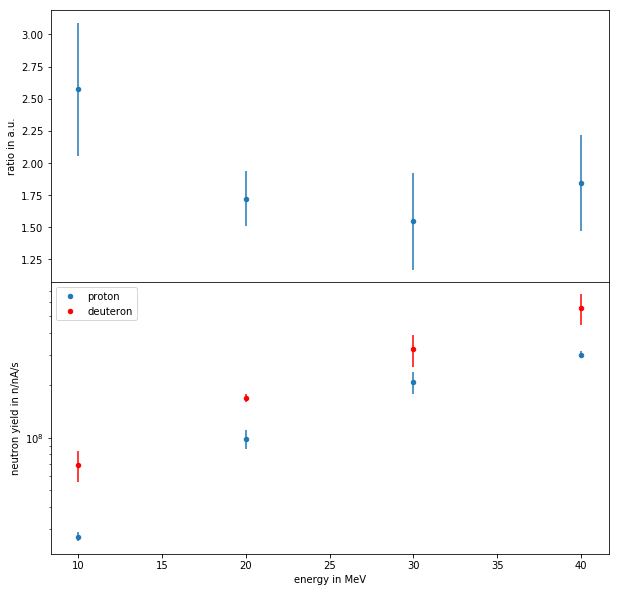

In [74]:
# plot neutron yield

fig,[ax3,ax1] = plt.subplots(2,1,sharex=True, figsize = (10,10))



df_proton.plot(
    x = 'energy',
    y = 'n_yield',
    yerr = 'n_yield error',
    kind = 'scatter',
    ax = ax1, 
    logy = True
)

df_deuteron.plot(
    x = 'energy',
    y = 'n_yield', 
    yerr = 'n_yield error',
    kind = 'scatter',
    ax = ax1,
    logy = True,
    c='r'
)

ax1.set_xlabel('energy in MeV')
ax1.set_ylabel('neutron yield in n/nA/s')
ax1.legend(['proton','deuteron'])

df_ratio.plot(
    x = 'energy',
    y = 'ratio', 
    yerr = 'ratio error',
    kind = 'scatter',
    ax = ax3
)

ax3.set_ylabel('ratio in a.u.')

plt.subplots_adjust(hspace = 0)

plt.savefig(PATH_TO_DATA + 'final_yield_plot.svg', format = 'svg', dpi = 900)
plt.savefig(PATH_TO_DATA + 'final_yield_plot.png', format = 'png', dpi = 900)
plt.show()

### testing

In [36]:
with open(PATH_TO_DATA + 'RawData/Gamma/' + '#34_40MeV_protonen_mit_Be.itx', newline = '') as file:
    lines = file.readlines()
    start = [num for num,s in enumerate(lines) if 'BEGIN' in s]
    end = [num for num,s in enumerate(lines) if 'END' in s]
    values = lines[start[0]+1:end[0]]
    values = [int(item.strip()) for item in values]
    
        